In [33]:
import pandas as pd
import spacy, copy
from queue import *
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
nlp = spacy.load('pt')
#nodes = pd.read_csv('data/Networks/MilkO/nodes.csv')
#edges = pd.read_csv('data/Networks/MilkO/edges.csv')

network = pd.read_csv('data/Networks/Merged/Merged.csv', sep=';')
network.head()

index        from          to
0      0        gado      cavalo
1      1      vermis  equilíbrio
2      2  inclinação     declive
3      3  substância     química
4      4  substância     mistura

In [34]:
dictionary = set()
for index, node in network.iterrows():
    dictionary.add(node['from'])
    dictionary.add(node['to'])

In [75]:
graph = {}
for index, edge in network.iterrows():
    if not(edge['from'] in graph):
        graph[edge['from']]={'weight':0, 'documents':dict(), 'edges':[]}
    if not(edge['to'] in graph):
        graph[edge['to']]={'weight':0, 'documents':dict(), 'edges':[]}
    graph[edge['from']]['edges'].append({'term':edge['to'],'weight':0})
           

In [36]:
graph

{'gado': {'weight': 0,
  'documents': [],
  'edges': [{'term': 'cavalo', 'weight': 0}]},
 'cavalo': {'weight': 0,
  'documents': [],
  'edges': [{'term': 'inverno', 'weight': 0},
   {'term': 'raça', 'weight': 0},
   {'term': 'brasil', 'weight': 0},
   {'term': 'transporte', 'weight': 0},
   {'term': 'agricultura', 'weight': 0},
   {'term': 'animal', 'weight': 0},
   {'term': 'espécie', 'weight': 0},
   {'term': 'genética', 'weight': 0}]},
 'vermis': {'weight': 0,
  'documents': [],
  'edges': [{'term': 'equilíbrio', 'weight': 0}]},
 'equilíbrio': {'weight': 0, 'documents': [], 'edges': []},
 'inclinação': {'weight': 0,
  'documents': [],
  'edges': [{'term': 'declive', 'weight': 0}]},
 'declive': {'weight': 0, 'documents': [], 'edges': []},
 'substância': {'weight': 0,
  'documents': [],
  'edges': [{'term': 'química', 'weight': 0},
   {'term': 'mistura', 'weight': 0},
   {'term': 'matéria', 'weight': 0},
   {'term': 'leite', 'weight': 0},
   {'term': 'composição química', 'weight': 0}

In [76]:
def processSent(graph, textEntry):
    tokenized = [lemmatizer(token.orth_, token.pos_)[0] for token in nlp(textEntry) if not (token.is_stop or token.is_punct or not token.is_alpha)]
    traversedList = set()
    i = 1
    for word in tokenized:
        if word in dictionary:
            graph[word]['weight']=1
            graph, traversedList = spread(word, graph, traversedList, previousScore=1)
            i=i+1
    return graph

def spread(word, graph, traversedList, previousScore=1, weight=1, decay=0.5,treshold=0.1):
    if graph[word]['weight']==0:
        graph[word]['weight']=previousScore
    futureTraversals = Queue()
    if (previousScore > treshold):
        for i in range(1, len(graph[word]['edges'])-1):
            if graph[word]['edges'][i].get('weight')==0:
                graph[word]['edges'][i].update({'weight':previousScore})
            graph[word]['edges'][i].update({'weight':graph[word]['edges'][i].get('weight')*decay})
            if graph[word]['edges'][i]['term'] not in traversedList:
                futureTraversals.put({'term':graph[word]['edges'][i].get('term'), 'weight':graph[word]['edges'][i].get('weight')})
                traversedList.add(graph[word]['edges'][i].get('term'))
        if(not futureTraversals.empty()):
            while not futureTraversals.empty():
                totraverse = futureTraversals.get()
                graph, traversedList = spread(word=totraverse['term'], graph=graph, traversedList=traversedList, previousScore=totraverse['weight'])

    else:
        return graph, traversedList
    return graph, traversedList

def activeGraph(graph):
    gcopy = copy.deepcopy(graph)
    itemsToPop = []
    for val in gcopy:
        if gcopy[val]['weight']==0:
            itemsToPop.append(val)
        else:
            for edge in gcopy[val]['edges']:
                if edge['weight'] ==0:
                    gcopy[val]['edges'].remove(edge)
    for item in itemsToPop:
        gcopy.pop(item, None)
    return gcopy


        


In [55]:
#%%pixie_debugger
g2 = copy.deepcopy(graph)
g2 = processSent(g2,"""
Olá, gostaria de saber a diferença entre: vacas secas, vacas solteiras e vacas amojando.

Agradeço desde já!

""")
print(activeGraph(g2))


{'cavalo': {'weight': 0.5, 'documents': set(), 'edges': [{'term': 'raça', 'weight': 0.25}, {'term': 'brasil', 'weight': 0.25}, {'term': 'transporte', 'weight': 0.25}, {'term': 'agricultura', 'weight': 0.25}, {'term': 'animal', 'weight': 0.25}, {'term': 'espécie', 'weight': 0.25}]}, 'vermis': {'weight': 0.0625, 'documents': set(), 'edges': []}, 'declive': {'weight': 0.0625, 'documents': set(), 'edges': []}, 'substância': {'weight': 0.0625, 'documents': set(), 'edges': [{'term': 'mistura', 'weight': 0}, {'term': 'leite', 'weight': 0}, {'term': 'água', 'weight': 0}]}, 'química': {'weight': 0.125, 'documents': set(), 'edges': [{'term': 'ureia', 'weight': 0.0625}, {'term': 'substância', 'weight': 0.0625}, {'term': 'fermentação', 'weight': 0.0625}, {'term': 'célula', 'weight': 0.0625}, {'term': 'estrela', 'weight': 0.0625}, {'term': 'organismo', 'weight': 0.0625}, {'term': 'proteína', 'weight': 0.0625}, {'term': 'arquitetura', 'weight': 0.0625}, {'term': 'alimento', 'weight': 0.0625}, {'term

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


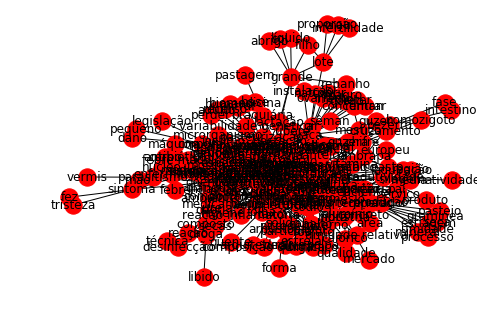

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
#%matplotlib inline
def toNetworkx(graph):
    G = nx.Graph()
    for node in graph:
        for edge in graph[node]['edges']:
            if edge['weight']!=0:
                G.add_edge(node, edge['term'])
    return G
G = toNetworkx(activeGraph(g2))
nx.draw(G, with_labels=True)
plt.draw()
plt.show()

In [103]:
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

def addDocument(graph, document_id, document_text, normalized = False, allowRepetitions = True):
    lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
    nlp = spacy.load('pt')
    termsInDocument = []
    for token in nlp(document_text):
        word = token.orth_
        if word in graph:
            termsInDocument.append(word)
            #graph[word]['documents'].add(document_id)
            continue
        lemmas = lemmatizer(token.orth_, token.pos_)
        for lemma in lemmas:
            if lemma in graph:
                termsInDocument.append(lemma)
                continue
    if allowRepetitions == False:
        termsInDocument = set(termsInDocument)
    toAdd = 1
    if normalized == True:
        toAdd = 1 /len(termsInDocument) if len(termsInDocument) > 0 else 1
    for term in termsInDocument:
        if document_id in graph[term]['documents']:
            graph[term]['documents'][document_id] +=toAdd
        else:
            graph[term]['documents'][document_id] = toAdd
        
    return graph

def getMostRanked(graph, input_string, listsize = 10):
    graph = activeGraph(processSent(graph, input_string))
    docvalues = dict()
    #print(type(graph))
    for entry in graph:
        #print(graph[entry]['documents'])
        for doc in graph[entry]['documents']:
            #print(doc)
            if doc in docvalues:
                docvalues[doc] = graph[entry]['weight']*graph[entry]['documents'][doc]+docvalues[doc]
            else:
                docvalues[doc] = graph[entry]['weight']*graph[entry]['documents'][doc]
    print(sorted(docvalues.items(), key=lambda kv: kv[1], reverse=True)[:listsize])
            
    

In [106]:
respostas = pd.read_csv('data/Raw/quinhentas_respostas.csv')
for idx, row in respostas.iterrows():
    graph = addDocument(graph, row['index'], row['resposta'], True, False)

In [108]:
getMostRanked(graph, "Quando iniciar os cuidados com os bezerros")

[(4, 13.070549242424239), (41, 11.81318224964404), (18, 10.406249999999995), (17, 10.09346846846847), (20, 9.847643272425252), (7, 9.358544435215949), (2, 9.192406692406694), (22, 8.782280219780217), (29, 8.35434149184149), (58, 6.810963983050845)]
